

# Notebook 1: Invloeden bepalen
*auteur: S.A. Klop*
    
Dit notebook laat zien hoe tijdreeksanalyse gebruikt kan worden om verschillende invloeden op de grondwaterstand te bepalen. 
    
Hierbij wordt gekeken naar het bepalen of een externe invloed, zoals een onttrekking, een significante invloed heeft en hoeveel deze invloed voor een verlaging of verhoging zorgt. Dit notebook is opgedeeld in twee delen. In het eerste deel wordt een voorbeeld behandeld met een onttrekking. In deel II van de notebook wordt gekeken naar de invloed van een waterloop op de grondwaterstand. 
   
**Inhoudsopgave**

- [Deel I: Invloed onttrekking](#Deel-I:-Invloed-onttrekking)
    - [Beschikbare data](#Beschikbare-data-voorbeeld-1)
    - [Opstellen tijdreeksmodel](#Opstellen-tijdreeksmodel-voorbeeld-1)
    - [Invloed van de ingreep](#Invloed-van-de-ingreep)
- [Deel II: Invloed waterloop](#Deel-II:-Invloed-waterloop)
    - [Beschikbare data](#Beschikbare-data-voorbeeld-2)
    - [Voorbewerken reeksen](#Voorbewerken-reeksen-voorbeeld-2)
    - [Opzetten model](#Opzetten-model-voorbeeld-2)
    - [Bepalen invloed waterloop](#Bepalen-invloed-van-waterloop)





In [1]:
# inladen van de benodigde python packages
import pastas as ps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

%matplotlib inline
ps.set_log_level("ERROR");

## Deel I: Invloed onttrekking

Het waterschap heeft de grondwaterstand gemeten in Peilbuis 1. De peilbuis bevindt zich in een gebied waar het waterschap in de zomer van 2005 maatregelen heeft genomen om de grondwaterstand in het gebied te verhogen om de natuurwaarden te verbeteren. Hiervoor zijn onder andere enkele stuwen omhoog gezet en enkele watergangen gedempt.

10 jaar na de ingrepen wil het waterschap evalueren of de ingrepen het gewenste effect hebben gehad op de grondwaterstand. Hiervoor wordt de grondwaterstand in Peilbuis 1 geanalyseerd met behulp van tijdreeksanalyse.


### Beschikbare data voorbeeld 1
In de onderstaande afbeelding is de gemeten grondwaterstand in Peilbuis 1 te zien. De grondwaterstand is gemeten voor de periode van 1985 tot en met 2015. De grondwaterstand is voor en na de ingreep gemeten. Op het eerste gezicht lijkt het alsof de grondwaterstand sinds de ingrepen in de zomer van 2005 hoger is geworden, echter is een direct effect lastig visueel waar te nemen. 

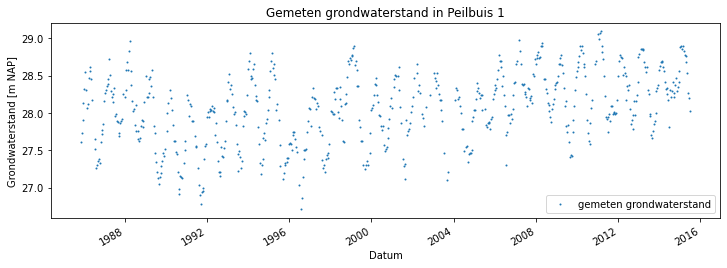

In [2]:
gws = pd.read_csv("data/head_stepex_edit.csv",
                   index_col=0, parse_dates=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van Peilbuis 1. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. 

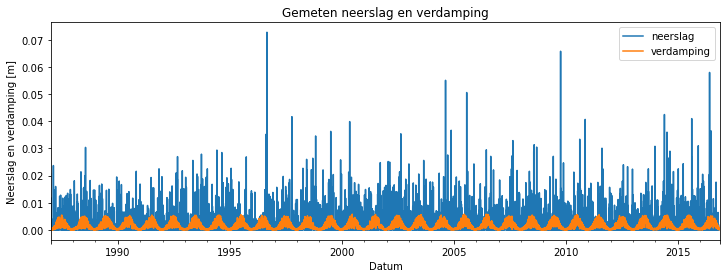

In [3]:
neerslag = pd.read_csv("data/rain_stepex.csv",
                   index_col=0, parse_dates=True)
verdamping = pd.read_csv("data/evap_stepex.csv",
                   index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);
ax.set_xlim(xmin='1987');

### Opstellen tijdreeksmodel voorbeeld 1
De eerste stap voor het opstellen van het model is het toevoegen van de grondwater observaties aan het model. Hiervoor wordt de volledige reeks gebruikt. In de reeks zijn geen uitschieters gevonden, er is daarom geen reden om de meetreeks voor te bewerken voordat deze in het model kan worden toegepast.

De neerslag en verdamping worden toegevoegd aan het model als verklarende reeksen. Om de verklaarende reeksen toe te voegen moet een `respons functie` worden toegekent aan de verklarende reeks (in dit geval regen en verdamping). De respons functie beschrijft de reactie van de grondwaterstand op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type respons functie kiest en waarbij het tijdreeksmodel de parameters van deze functie optimaliseerd. Voor het tijdreeksmodel wordt gebruikt gemaakt van de Gamma respons functie voor de neerslag en verdamping. 

In het tijdreeksmodel wordt dezelfde response functie gebruikt voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule:

$ R = P - f * E$

waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd. Naast de verklarende reeksen wordt ook een constante (in het tijdreeksmodel $d$) meegefit in het model.

Na het toevoegen van de observaties en de verklarende reeksen kan het tijdreeksmodel worden geoptimaliseerd. De resultaten van het tijdreeksmodel zijn te zien in de onderstaande tabel.

In [4]:
# opzetten model
ml = ps.Model(gws)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve();

Model Results head                             Fit Statistics
nfev     19                     EVP                     70.62
nobs     644                    R2                       0.71
noise    True                   RMSE                     0.26
tmin     1985-11-14 00:00:00    AIC                      4.50
tmax     2015-06-28 00:00:00    BIC                     31.31
freq     D                      Obj                      2.30
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (6 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  753.905642  ±10.26%  215.674528  True
grondwateraanvulling_n    1.022537   ±1.79%    1.000000  True
grondwateraanvulling_a  155.446461  ±11.65%   10.000000  True
grondwateraanvulling_f   -1.170904   ±6.02%   -1.000000  True
constant_d               27.913055   ±0.39%   28.061491  True
noise_alpha             276.388172  ±23

Het model heeft een verklaarde variantie van 71% en een R$^2$ van 0,71. Met behulp van het geoptimaliseerde tijdreeksmodel kan de grondwaterstand worden gesimuleerd. De simulatie van de grondwaterstand is te zien in de onderstaande afbeelding. Naast de gesimuleerde grondwaterreeks zijn ook de residuen van de simulatie en de bijdrage van de neerslag en verdamping weergeven.

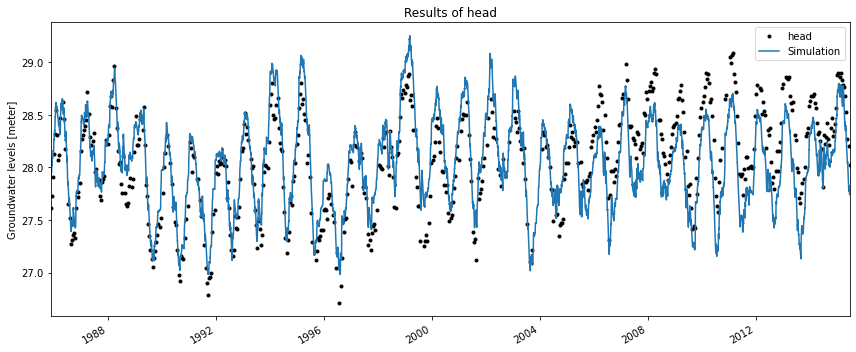

In [5]:
ml.plot(figsize=(12,5));

In de simulatie is te zien dat het tijdreeksmodel op de gemeten grondwaterstand redelijk simuleerd. Een visuele inspectie laat zien dat het model voor de periode na 2005 niet in staat is om de pieken van de grondwatermeetreeks goed te simuleren. Dit is ook zichtbaar in de residuen van de reeks. Deze zijn weergeven in de onderstaande afbeelding. Hierin is nog duidelijker zichtbaar dat een ingreep in het gebied heeft plaatsgevonden. 

In de periode voor 2005 overschat het model de gemeten grondwaterstand. In de periode na 2005 maakt het model een onderschatting. Dit sugereert dat rond 2005 een verandering in het systeem heeft plaatsgevonden.

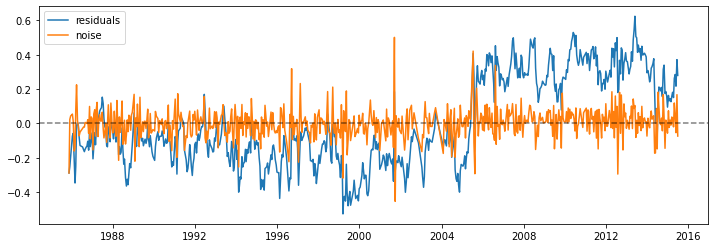

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(ml.residuals(), label='residuals')
ax.plot(ml.noise(), label='noise')
ax.axhline(0, color='k', ls='--', alpha=0.5)
ax.legend()

### Invloed van de ingreep

Het tijdreeksmodel wordt nogmaals opgesteld, met als doel de invloed van de ingreep te bepalen. Ten eerste wordt geprobeerd het model op te stellen met de toevoeging van een stap respons.

Deze stap respons wordt toegevoegd aan het huidige tijdreeksmodel. Voor de stap respons wordt de `One` respons functie gebruikt. Deze functie simuleerd een instantane reactie van het grondwater op de verklarende reeks. De stap respons wordt opgelegt op het moment waarop de ingrepen in het gebied zijn ingevoerd, 1 juni 2005. In de onderstaande tabel zijn de modelresultaten te zien.

In [7]:
# opzetten model
ml = ps.Model(gws)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

sm2 = ps.StepModel(tstart=pd.Timestamp('2005-06-01'), name='stap', rfunc=ps.One, up=None)
ml.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml.solve();

Model Results head                                    Fit Statistics
nfev     18                     EVP                            94.23
nobs     644                    R2                              0.94
noise    True                   RMSE                            0.11
tmin     1985-11-14 00:00:00    AIC                            11.76
tmax     2015-06-28 00:00:00    BIC                            47.50
freq     D                      Obj                             2.01
warmup   3650 days 00:00:00     ___                                 
solver   LeastSquares           ___                                 

Parameters (7 were optimized)
                              optimal   stderr        initial   vary
grondwateraanvulling_A     683.156837   ±5.20%     215.674528   True
grondwateraanvulling_n       1.016843   ±1.79%       1.000000   True
grondwateraanvulling_a     151.609511   ±7.50%      10.000000   True
grondwateraanvulling_f      -1.279803   ±4.77%      -1.000000   True
sta

Zoals te zien zijn de verklaarde variantie en de R$^2$ van het nieuwe model significant hoger dan het oude model zonder stap trend. De stap die door het tijdreeksmodel wordt berekend is gelijk aan 0.48 meter. De stap trend is te zien in de afbeelding hier onder, hierbij is het 95% zekerheidsinterval weergeven van de hoogte van de stap.

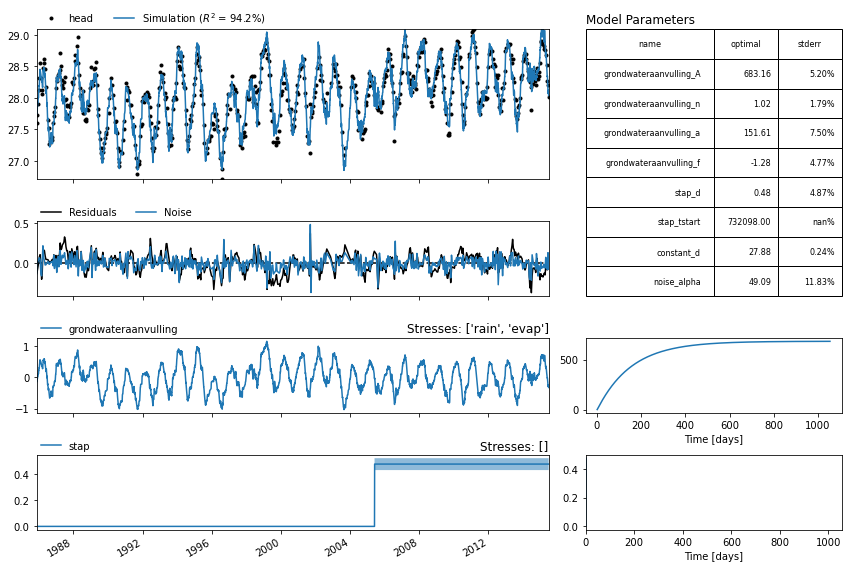

In [8]:
ci = ml.fit.ci_contribution("stap", alpha=0.05)
axes = ml.plots.results(adjust_height=False, figsize=(12,8))
axes[-2].fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], zorder=-10, alpha=0.5);

In de onderstaande afbeelding zijn de residuen van het nieuwe tijdreeksmodel te zien. Hierbij is zichtbaar dat de trend in de residuen, die zichtbaar was bij het eerste tijdreeksmodel, niet in meer voorkomt bij het nieuwe tijdreeksmodel.

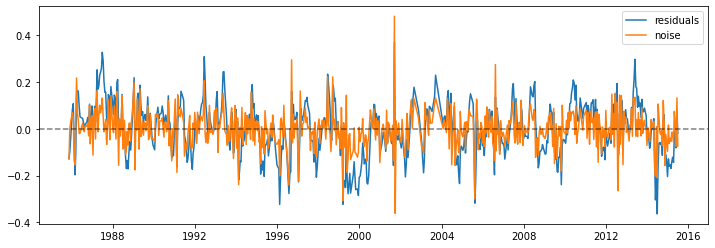

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(ml.residuals(), label='residuals')
ax.plot(ml.noise(), label='noise')
ax.axhline(0, color='k', ls='--', alpha=0.5)
ax.legend()

Om het berekende effect te valideren wordt een tweede methode toegepast om de verhoging ten gevolge van de ingrepen te bepalen. Hiervoor worden 2 tijdreeksmodellen opgesteld; een model voor dat de ingreep heeft plaatsgevonden (model tot mei 2005) en een model na de ingrepen (model vanaf september 2005). Hierbij worden de neerslag en verdamping als verklarende reeksen gebruikt. Net als bij het vorige tijdreeksmodel wordt de Gamma respons functie gebruikt. Aan beide modellen wordt geen stap trend toegevoegd.

In [10]:
# opzetten model
ml_voor = ps.Model(gws[:'2005-05-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml_voor.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml_voor.solve(report=False);

# opzetten model
ml_na = ps.Model(gws['2005-09-01':])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml_na.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml_na.solve(report=False);

Met behulp van beide modellen kan de grondwaterstand worden gesimuleerd. Met beide modellen wordt de periode van 1995 tot en met 2015 gesimuleerd, 10 jaar voor en na de ingrepen. In de onderstaande figuur zijn beide simulaties weergeven, daarnaast is ook het verschil tussen beide simulaties berekend voor deze periode.

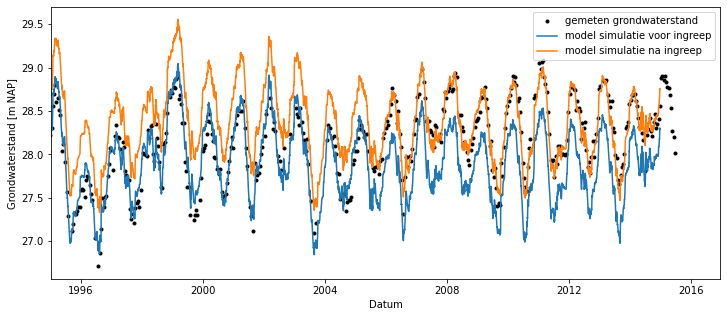

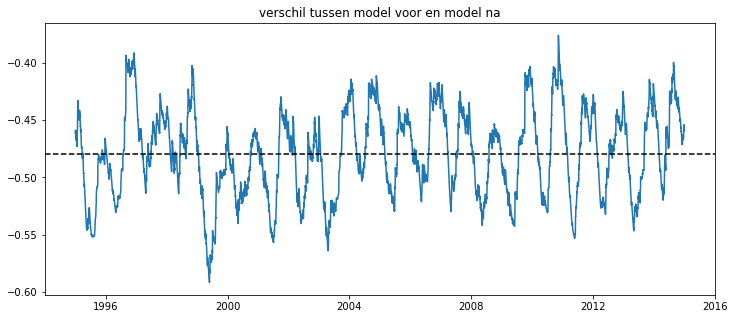

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(12,5))
ax.plot(gws, marker='.', color='k', ls='', label='gemeten grondwaterstand')
ax.plot(ml_voor.simulate(tmin='1995', tmax='2015'), label='model simulatie voor ingreep')
ax.plot(ml_na.simulate(tmin='1995', tmax='2015'), label='model simulatie na ingreep')

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_xlim(xmin='1995')
ax.legend();

fig, ax = plt.subplots(1, 1,figsize=(12,5))
ax.plot(ml_voor.simulate(tmin='1995', tmax='2015') - ml_na.simulate(tmin='1995', tmax='2015',),
        color='C0', label='verschil tussen modellen')
ax.axhline((ml_voor.simulate(tmin='1995', tmax='2015') - ml_na.simulate(tmin='1995', tmax='2015')).mean(),
          color='k', ls='--', label='gemiddelde verschil')
ax.set_title('verschil tussen model voor en model na');

Zoals te zien is het verschil tussen beide modellen tussen de 0.4 en 0.6 meter. Het gemiddelde verschil is 0.48 meter. Dit suggereert dat de ingrepen die hebben plaatsgevonden in 2005 een effect hebben gehad van 0.48 meter op de grondwaterstand. Dit komt overeen met de bevindingen van het tijdreeksmodel met de stap respons functie, hiermee kan deze model conclusie worden ondersteund.

## Deel II: Invloed waterloop

Het waterschap heeft nabij een grote waterloop een peilbuis staan om de grondwaterstand in het gebied te monitoren. Het is bij de beheerder van het gebied bekent dat de waterstand in de waterloop sterk aan elkaar zijn gecorreleerd. 

In de zomer van 2018 is de waterstand in de waterloop door de droogte sterkt gedaald, om te zorgen dat het gebied bij een volgende droge periode niet teveel verdroogd wordt het verhogen van de waterstand in de waterloop een oplossing kan zijn voor de lage grondwaterstand. De hydroloog van het waterschap wil bepalen hoe de grondwaterstand in het gebied reageert op veranderingen van de waterstand in de waterloop.

### Beschikbare data voorbeeld 2

De grondwaterstand is gemeten voor de periode van 2000 tot 2020. De gemeten grondwaterstand is  weergeven in de onderstaande afbeelding. Te zien is dat in de zomer van 2018 de grondwaterstand sterk is gedaald.  

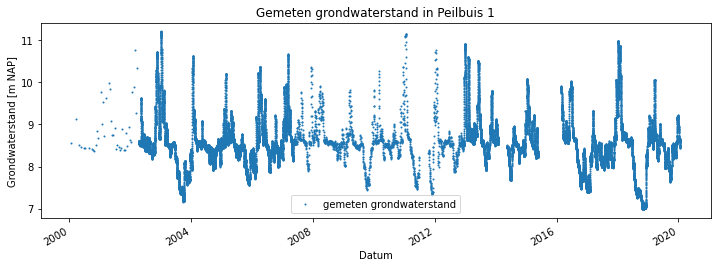

In [12]:
gws = pd.read_csv("data/head_rivex.csv",
                   index_col="Date", parse_dates=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);

Nabij het gebied zijn de neerslag en verdampingsgegevens opgehaald van het KNMI weerstation. De neerslag en verdamping zijn weergeven in de onstaande afbeelding. 

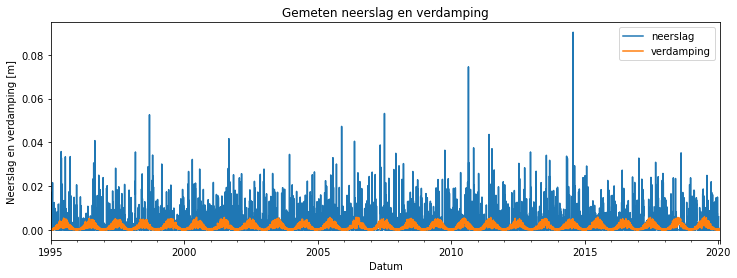

In [13]:
neerslag =  pd.read_csv("data/prec_rivex.csv",
                    index_col="Date", parse_dates=True)
verdamping =  pd.read_csv("data/evap_rivex.csv",
                    index_col="Date", parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);
ax.set_xlim(xmin='1995');

Naast de neerslag en verdamping wordt voor het tijdreeksmodel de waterstand in de waterloop gebruikt als verklarende reeks. In de waterloop is door het waterschap de waterstand gemeten voor de periode 1995 tot 2020. De variatie in waterstand ten opzichte van het streefpeil is te zien in de onstaande figuur. In de meetreeks is te zien dat de waterstand in de zomer van 2018 erg laag was, ca. 2 meter onder het streefpeil. 


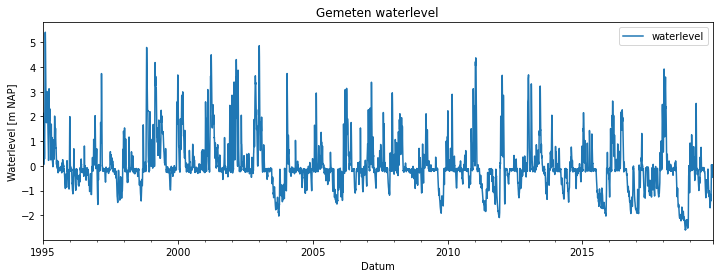

In [14]:
waterlevel = pd.read_csv("data/waterlevel_rivex.csv",
                   index_col="Date", parse_dates=True)

# plotten van het waterlevel
fig, ax = plt.subplots(1, 1, figsize=(12,4))
waterlevel.plot(ax=ax, color='C0')

# opmaken van de figuur
ax.set_ylabel('Waterlevel [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten waterlevel')
ax.legend([f'waterlevel']);
ax.set_xlim(xmin='1995');

### Voorbewerken reeksen voorbeeld 2

De gemeten grondwaterstand heeft een meetfrequentie van eens per 3 uur. De meetreeks van het waterniveau in de waterloop heeft een meetfrequentie van eens per dag, net als de neerslag en de verdamping. Hierom wordt de meetreeks van de grondwaterstand geresampled naar een frequentie van eens per dag, gelijk aan de verklarende reeksen. Hiervoor wordt de gemiddelde grondwaterstand per dag genomen bij het resampelen van de meetreeks.

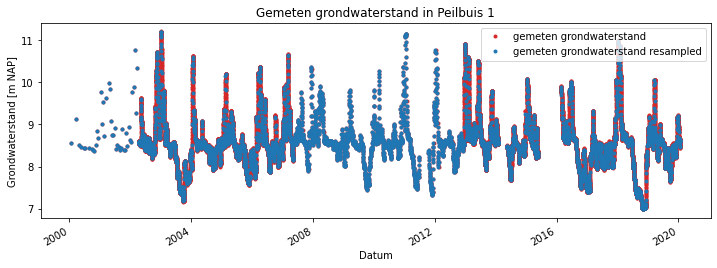

In [15]:
gws_r = gws.resample("D").mean().dropna()

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws.plot(ax=ax, color='C3', ls='', marker='.')
gws_r.plot(ax=ax, color='C0', ls='', marker='.')

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand', 'gemeten grondwaterstand resampled']);


### opzetten model voorbeeld 2

Met de bewerkte meetreeks wordt een tijdreeksmodel opgezet voor de periode vanaf 2000. Eerst is een model opgesteld met enkel neerslag en verdamping als verklarende reeksen. Voor deze reeksen is de Gamma respons functie gebruikt.

De resultaten van het model zijn te zien in de onderstaande tabel. 

In [16]:
# opzetten model
ml = ps.Model(gws_r[2000:])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve();

Model Results Head                                     Fit Statistics
nfev     17                     EVP                             15.90
nobs     4047                   R2                               0.16
noise    True                   RMSE                             0.54
tmin     2007-08-22 00:00:00    AIC                             -2.18
tmax     2020-01-21 00:00:00    BIC                             35.66
freq     D                      Obj                              9.79
warmup   3650 days 00:00:00     ___                                  
solver   LeastSquares           ___                                  

Parameters (6 were optimized)
                             optimal                        stderr  \
grondwateraanvulling_A  1.084349e+02                        ±6.31%   
grondwateraanvulling_n  3.276733e+00                        ±4.24%   
grondwateraanvulling_a  2.917933e+00                        ±6.64%   
grondwateraanvulling_f -5.778684e-22  ±34028428299060727775

In de onderstaande afbeelding is de gesimuleerde grondwaterstand weergeven. Te zien is dat het tijdreeksmodel geen goede verklaring geeft voor de gemeten grondwaterstand. Het model is niet in staat om de variatie in grondwaterstand te simuleren.

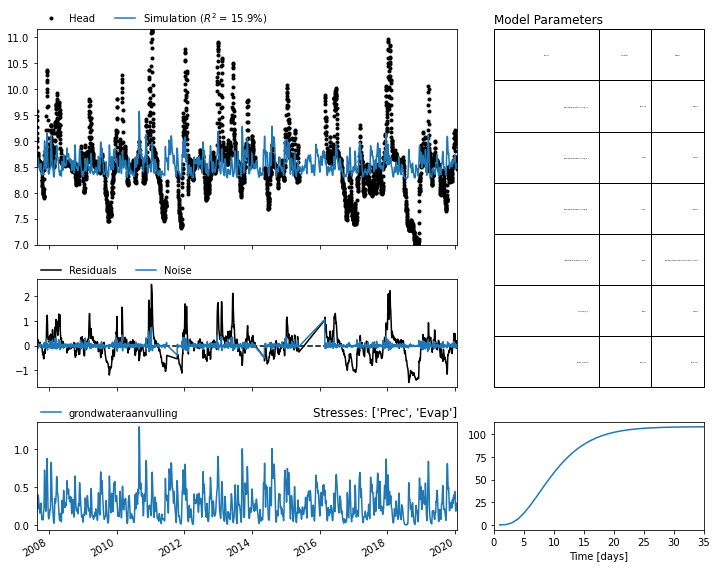

In [17]:
ml.plots.results();


Er wordt nogmaals een tijdreeksmodel opgesteld, nu met de toevoeging van de gemeten waterstand in de waterloop als verklarende reeks. De variatie van het waterpeil is ca. 6 a 7 meter, de variatie van het grondwater is ca. 4 meter. Omdat de grondwaterstand sterk afhankelijk lijkt te zijn van de waterstand in de waterloop kan op basis van deze visuele inspectie een inschatting te maken van de respons van het grondwater op de waterloop. Naar verwachting zal deze rond de 57% tot 66% zijn (tussen de 4/6 en 4/7).  

De resultaten van het 2de model zijn te zien in de onderstaande tabel. 

In [18]:
# opzetten model
ml2 = ps.Model(gws_r[2000:])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml2.add_stressmodel(sm1)

sm2 = ps.StressModel(stress=waterlevel,
                    rfunc=ps.Gamma,
                    name='waterlevel',
                    settings='waterlevel')
ml2.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml2.solve()

Model Results Head                            Fit Statistics
nfev     37                     EVP                    95.29
nobs     4047                   R2                      0.95
noise    True                   RMSE                    0.13
tmin     2007-08-22 00:00:00    AIC                     9.59
tmax     2020-01-21 00:00:00    BIC                    66.34
freq     D                      Obj                     3.21
warmup   3650 days 00:00:00     ___                         
solver   LeastSquares           ___                         

Parameters (9 were optimized)
                          optimal   stderr     initial  vary
grondwateraanvulling_A  25.800414  ±14.92%  183.785267  True
grondwateraanvulling_n   1.967217   ±6.14%    1.000000  True
grondwateraanvulling_a   3.839466  ±15.28%   10.000000  True
grondwateraanvulling_f  -0.424683  ±74.81%   -1.000000  True
waterlevel_A             0.572214   ±6.52%    1.000000  True
waterlevel_n             0.100000   ±9.36%    1.000000

In de onderstaande afbeelding is de simulatie van het tijdreeksmodel te zien. Hierbij is te zien dat het tijdreeksmodel de gemeten grondwaterstand significant beter simuleerd dan het tijdreeksmodel zonder het waterniveau in de waterloop. De verklaarde variantie van dit tijdreeksmodel is 95% ten opzichte van 16% van het eerste model. Hierin is ook te zien dat het tijdreeksmodel de grondwaterstand in de zomer van 2018 goed inschat. 

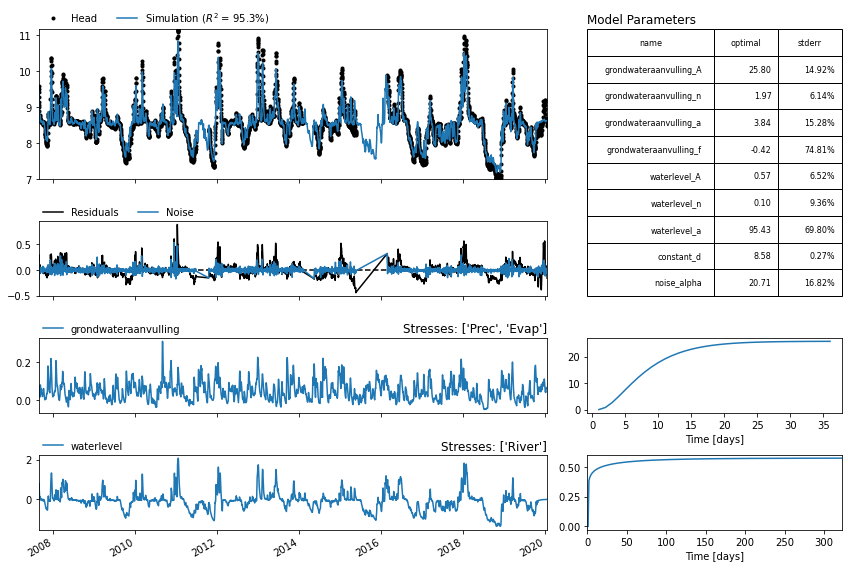

In [21]:
ml2.plots.results(figsize=(12,8));

### Bepalen invloed van waterloop

In de onderstaande figuur is de bijdrage van de waterloop te zien voor het grondwater niveau. Hierbij is te zien dat de variatie in waterstand zorgt voor een bijdrage van ca. -2 tot 2 m op de gemeten grondwaterstand. Aan de bijdrages van de verschillende verklarende reeksen is te zien dat de waterloop de meeste bijdrage levert aan de variatie van de grondwaterstand. De stationaire waarde van de respons van de onttrekking is gelijk aan 0.57 meter (parameter `waterlevel_A` in het tijdreeksmodel, de 'gain' van de respons), dit betekent dat de grondwaterstand 0.57 meter stijgt bij een waterstandsverhoging van 1 m in de waterloop. Dit komt goed overeen met het beeld wat vooraf werd afgeleid uit de visuele inspectie van de reeks, namelijk een verhouding van ca. 2:1 tussen de stijging van de waterstand en grondwaterstand.

Met deze informatie kan de hydroloog het Waterschap adviseren. Uit het tijdreeksmodel blijkt dat de waterloop een significante invloed heeft op de grondwaterstand in het gebied. Daarnaast kan, met behulp van het tijdreeksmodel, een inschatting worden gemaakt van bijvoorbeeld de toelaatbare verlaging van de waterstand in de waterloop voordat de grondwaterstand onder een niveau komt waarbij droogteschade ontstaat in het gebied waar de peilbuis zich bevind. 

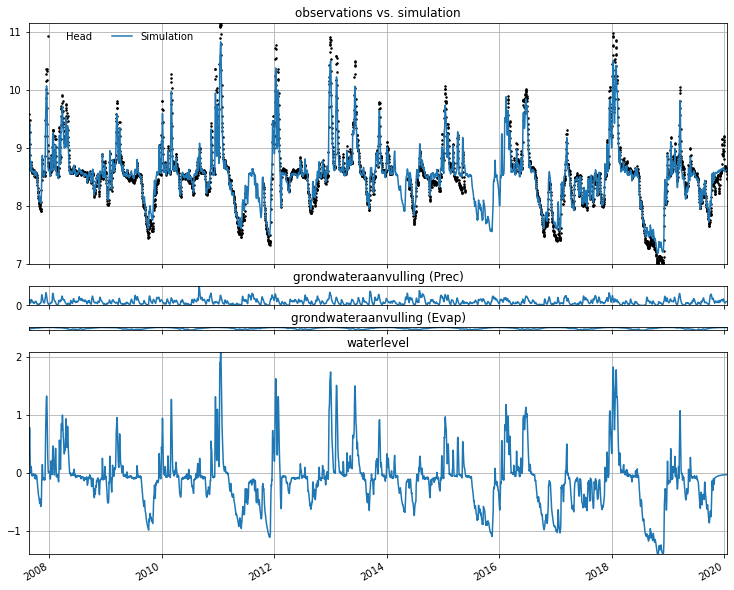

In [20]:
ml2.plots.decomposition();